In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import itertools
import os
import collections

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import scipy.io as spio
import tensorflow as tf
%matplotlib inline

from six.moves import urllib

In [2]:
URL_TRAIN_PATH = "http://ufldl.stanford.edu/housenumbers/train_32x32.mat"
URL_TEST_PATH = "http://ufldl.stanford.edu/housenumbers/test_32x32.mat"

DOWNLOAD_FILENAME_TRAIN = "housenumbers_training.mat"
DOWNLOAD_FILENAME_TEST = "housenumbers_test.mat"

In [3]:
def download_data():
    if not os.path.exists(DOWNLOAD_FILENAME_TRAIN):
        filename, _ = urllib.request.urlretrieve(URL_TRAIN_PATH,DOWNLOAD_FILENAME_TRAIN)
    if not os.path.exists(DOWNLOAD_FILENAME_TEST):
        filename, _ = urllib.request.urlretrieve(URL_TEST_PATH,DOWNLOAD_FILENAME_TEST)
    print("TRAIN CSV")
    print("Found and downloaded file from {}".format(URL_TRAIN_PATH))
    print("Downloaded Filename: {}".format(DOWNLOAD_FILENAME_TRAIN))
    print("TEST CSV")
    print("Found and downloaded file from {}".format(URL_TEST_PATH))
    print("Downloaded Filename: {}".format(DOWNLOAD_FILENAME_TEST))

In [4]:
download_data()

TRAIN CSV
Found and downloaded file from http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Downloaded Filename: housenumbers_training.mat
TEST CSV
Found and downloaded file from http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Downloaded Filename: housenumbers_test.mat


In [5]:
train_mat = spio.loadmat(DOWNLOAD_FILENAME_TRAIN,squeeze_me=True)
test_mat = spio.loadmat(DOWNLOAD_FILENAME_TEST,squeeze_me=True)

In [6]:
type(train_mat)

dict

In [7]:
train_mat.keys()

dict_keys(['y', 'X', '__header__', '__globals__', '__version__'])

In [8]:
X_train = train_mat['X']
y_train = train_mat['y']

X_test = test_mat['X']
y_test = test_mat['y']

						Train Images


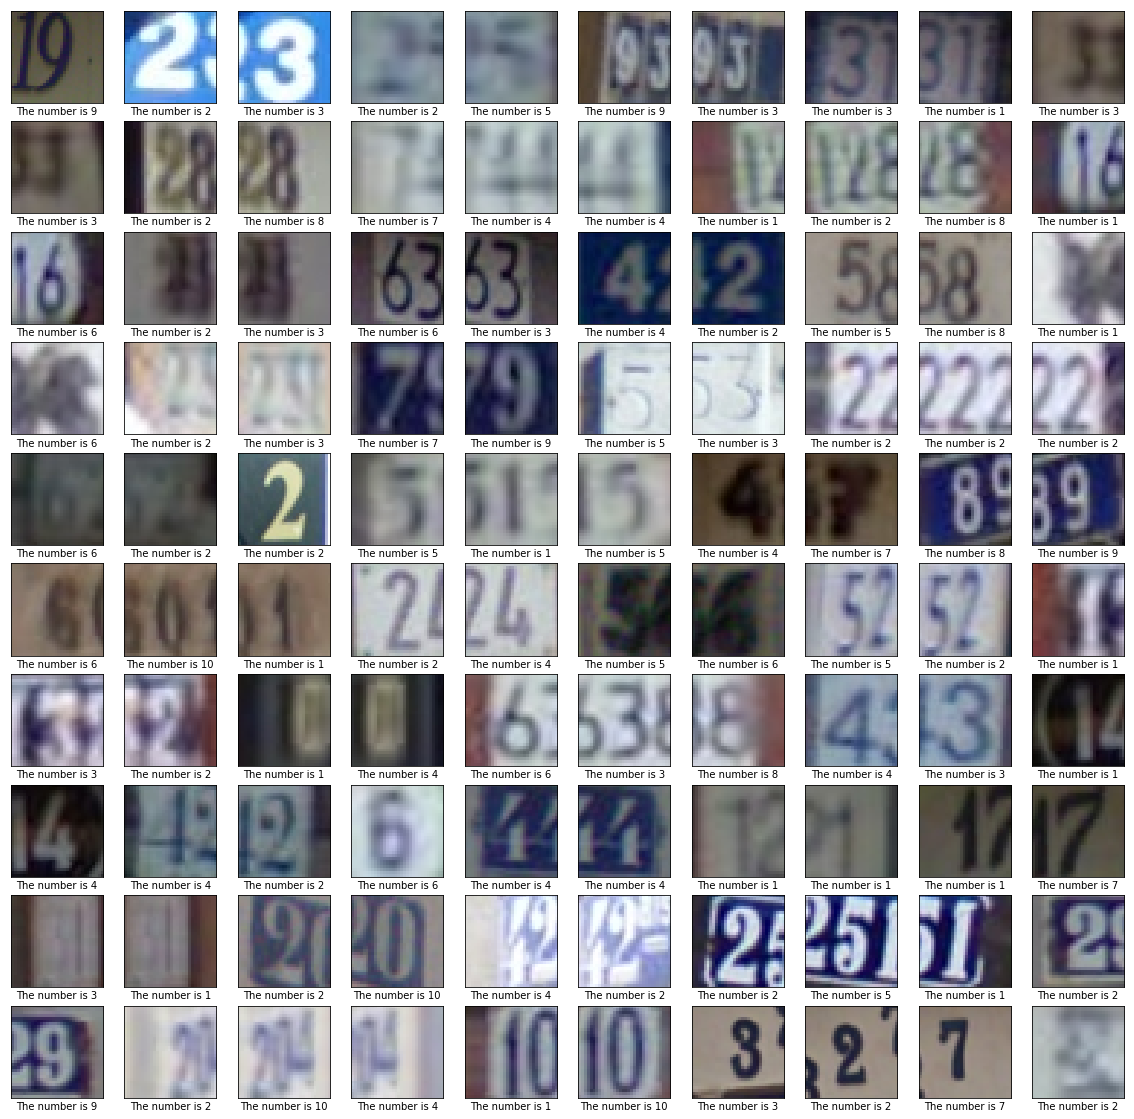

In [9]:
print("\t\t\t\t\t\tTrain Images")
plt.figure(figsize=(20,20))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(X_train[:,:,:,i+1],cmap='binary',interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.xlabel("The number is {}".format(y_train[i+1]))

						Test Images


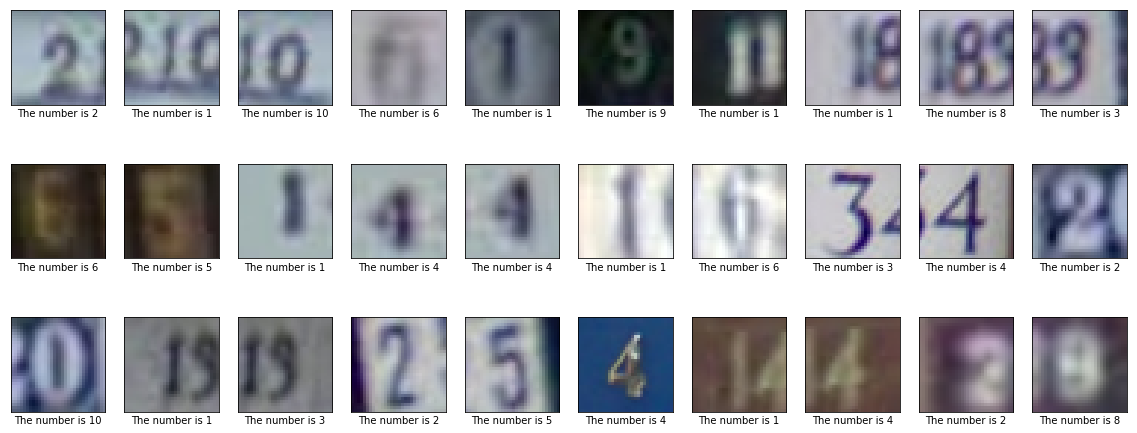

In [10]:
print("\t\t\t\t\t\tTest Images")
plt.figure(figsize=(20,8))
for i in range(30):
    plt.subplot(3,10,i+1)
    plt.imshow(X_test[:,:,:,i+1],cmap='binary',interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.xlabel("The number is {}".format(y_test[i+1]))

In [11]:
X_train = np.transpose(X_train, axes = (3,0,1,2))

In [12]:
X_test = np.transpose(X_test, axes = (3,0,1,2))

In [134]:
X_train = X_train[:25000]
X_test = X_test[:2000]

y_train = y_train[:25000]
y_test = y_test[:2000]

In [135]:
X_train[0].shape

(32, 32, 3)

In [136]:
y_train[:5]

array([1, 9, 2, 3, 2], dtype=uint8)

In [137]:
height = 32
width = 32
channels = 3
n_inputs = 32*32

In [138]:
conv1_feature_maps = 32
conv1_kernel_size = 3
conv1_stride = 1
conv1_pad = "SAME"

In [139]:
conv2_feature_maps = 64
conv2_kernel_size = 3
conv2_stride = 2
conv2_pad = "SAME"

In [140]:
pool3_feature_maps = conv2_feature_maps

In [141]:
n_dense1 = 128
n_dense2 = 64
n_output = 11

In [142]:
def tf_reset():
    try:
        tf.close()
    except:
        pass
    tf.reset_default_graph()

In [143]:
tf_reset()

In [144]:
X = tf.placeholder(tf.float32, shape=[None, height, width, channels], name = 'X')

In [145]:
y = tf.placeholder(tf.int32,shape=[None], name='y')

In [146]:
conv1 = tf.layers.conv2d(X,filters=conv1_feature_maps, kernel_size=conv1_kernel_size, strides = conv1_stride, padding=conv1_pad, activation=tf.nn.relu,name='conv1')

In [147]:
conv2 = tf.layers.conv2d(conv1, filters=conv2_feature_maps, kernel_size=conv2_kernel_size, strides=conv2_stride,padding=conv2_pad,activation=tf.nn.relu,name='conv2')

In [148]:
conv1.shape

TensorShape([Dimension(None), Dimension(32), Dimension(32), Dimension(32)])

In [149]:
conv2.shape

TensorShape([Dimension(None), Dimension(16), Dimension(16), Dimension(64)])

In [150]:
pool3 = tf.nn.max_pool(conv2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')

In [151]:
pool3_flat = tf.reshape(pool3,shape=(-1,pool3_feature_maps*8*8))

In [152]:
dense1 = tf.layers.dense(pool3_flat,n_dense1,activation=tf.nn.relu,name='dense1')

In [153]:
logits = tf.layers.dense(dense1,n_output,name='outputs')

In [154]:
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,labels=y,name='xentropy')

In [155]:
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(0.001)
train = optimizer.minimize(loss)

In [156]:
correct = tf.nn.in_top_k(logits,y,1,name='correct')

In [157]:
accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))

In [158]:
init = tf.global_variables_initializer()

In [159]:
current_iteration = 0
def get_next_batch(batch_size):
    
    global current_iteration
    
    start_index = (current_iteration * batch_size) % len(y_train)
    end_index = start_index + batch_size
    
    x_batch = X_train[start_index:end_index]
    y_batch = y_train[start_index:end_index]
    
    current_iteration += 1
    
    return x_batch, y_batch

In [160]:
n_epochs = 10
batch_size = 100

In [161]:
train_accuracy = []
test_accuracy = []
train_loss = []
test_loss = []
print("Training in Progress...")
with tf.Session() as sess:
    sess.run(init)
    
    num_example = len(y_train)
    for epoch in range(n_epochs):
        for iteration in range(num_example // batch_size):
            X_batch, y_batch = get_next_batch(batch_size)
            sess.run(train,feed_dict={X:X_batch, y:y_batch})
        
        acc_train = sess.run(accuracy,feed_dict={X:X_batch, y:y_batch})
        acc_test = sess.run(accuracy,feed_dict={X:X_test,y:y_test})
        loss_train = sess.run(loss,feed_dict={X:X_batch,y:y_batch})
        loss_test = sess.run(loss, feed_dict={X:X_test,y:y_test}) 
        
        train_accuracy.append(acc_train)
        test_accuracy.append(acc_test)
        train_loss.append(loss_train)
        test_loss.append(loss_test)
        
        print("Epoch {}, Train Accuracy: {}, Test Accuracy: {}".format(epoch,acc_train,acc_test))
    print("Training Almost Done!")
print("Model Trained.")

Training in Progress...
Epoch 0, Train Accuracy: 0.27000001072883606, Test Accuracy: 0.3009999990463257
Epoch 1, Train Accuracy: 0.6499999761581421, Test Accuracy: 0.6179999709129333
Epoch 2, Train Accuracy: 0.7400000095367432, Test Accuracy: 0.6010000109672546
Epoch 3, Train Accuracy: 0.800000011920929, Test Accuracy: 0.6629999876022339
Epoch 4, Train Accuracy: 0.800000011920929, Test Accuracy: 0.6579999923706055
Epoch 5, Train Accuracy: 0.7900000214576721, Test Accuracy: 0.6930000185966492
Epoch 6, Train Accuracy: 0.7799999713897705, Test Accuracy: 0.6620000004768372
Epoch 7, Train Accuracy: 0.7799999713897705, Test Accuracy: 0.6869999766349792
Epoch 8, Train Accuracy: 0.8299999833106995, Test Accuracy: 0.6980000138282776
Epoch 9, Train Accuracy: 0.8500000238418579, Test Accuracy: 0.7139999866485596
Training Almost Done!
Model Trained.


In [164]:
epochs = np.arange(0,10,1)

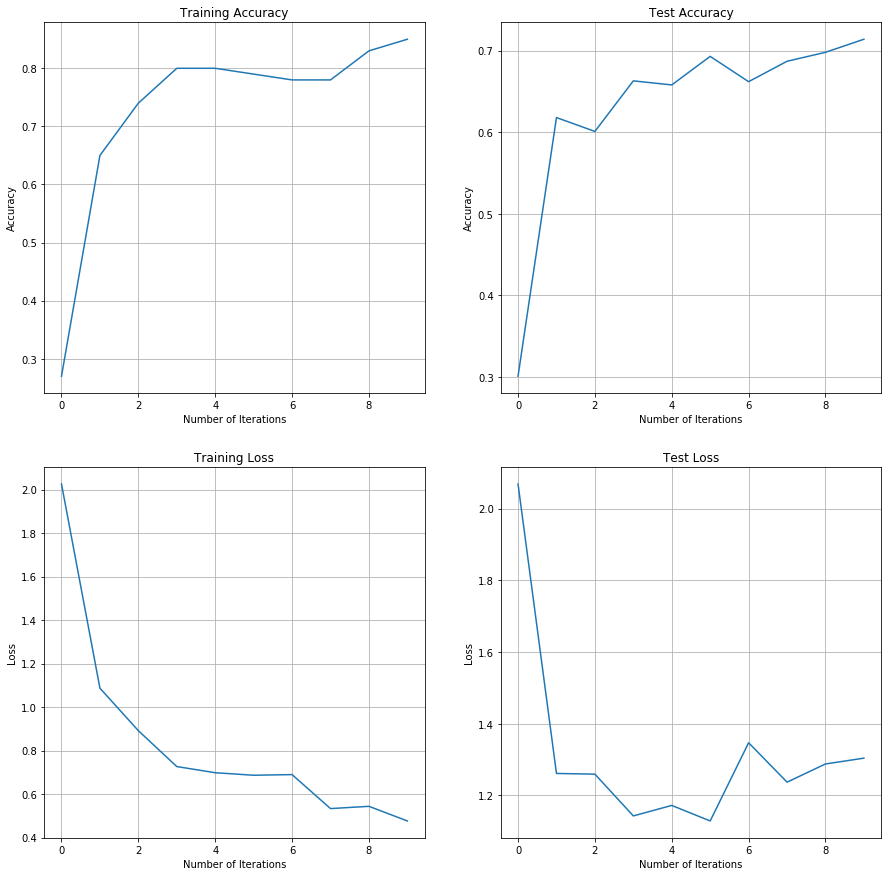

In [165]:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.grid(True)
plt.xlabel('Number of Iterations')
plt.ylabel('Accuracy')
plt.plot(epochs, np.array(train_accuracy))
plt.title('Training Accuracy')

plt.subplot(2,2,2)
plt.grid(True)
plt.xlabel('Number of Iterations')
plt.ylabel('Accuracy')
plt.plot(epochs, np.array(test_accuracy))
plt.title('Test Accuracy')

plt.subplot(2,2,3)
plt.grid(True)
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.plot(epochs, np.array(train_loss))
plt.title('Training Loss')

plt.subplot(2,2,4)
plt.grid(True)
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.plot(epochs, np.array(test_loss))
plt.title('Test Loss')
